# HW_1 MPI

## Дисклеймер

### Описание

Работа состоит из четырех частей:
- Основная (чистый MPI)
- Чистый OpenMP (ради интереса, код идентичен тому, что использован в MPI)
- Дополнительная (MPI + OpenMP +20%)
- Выводы

Проект собирается при помощи cmake, потому под бинарники отводится директория `build`. Данные и сгенерированные графики будут находиться в директории ноутбука.

### Конфигурация (или кто не любит параметрические тесты?)

Собирать данные времени необходимо, очевидно, с некоторым усреднением, потому отдельно к каждой части будет приложен блок с конфигурационными параметрами. Необходимые импорты и сборка ниже.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Компилируем исходники
os.system('cmake -B ../build ../ && cmake --build ../build')

-- Configuring done (1.8s)
-- Generating done (0.0s)
-- Build files have been written to: /home/cd7567/Documents/MIPT/IT/Sem_5/mpi/hw_1/build
[ 33%] Built target mpi
[ 66%] Built target omp
[ 83%] Building CXX object CMakeFiles/mpi_omp.dir/src/mpi_omp.cxx.o
[100%] Linking CXX executable mpi_omp
[100%] Built target mpi_omp


0

## Основная часть

Конфигурация тестирования:
- `MPI_DATA_FILE_NAME` -- файл, в который будут собираться данные
  
- `RUNS_NUMBER` -- количество запусков программы для каждой пары (p, N) с целью усреднения
- `MAX_PROCESS_NUMBER` -- количество запускаемых процессов варьируется в диапазоне [1, `MAX_PROCESS_NUMBER`]
- `N_ARRAY` -- выбранные для тестирования разбиения отрезка интегрирования

In [2]:
MPI_DATA_FILE_NAME = 'data_mpi.csv'

RUNS_NUMBER = 20
MAX_PROCESS_NUMBER = 8

N_array = [1000, 1000000, 100000000]

Подготовимся к сбору данных - cоздадим заголовок для таблицы. Данная реализация использует csv, заполняемый непосредственно кодом C++.

In [3]:
# Создаем файл для данных (удаляем имеющийся, если уже существует)
os.system('rm {}'.format(MPI_DATA_FILE_NAME))
csv_file = open(MPI_DATA_FILE_NAME, 'x')

# Пишем шапку таблицы
csv_file.write('p,    N,    seq_result,    seq_time,    par_result,    par_time\n')

# Закрываем файл
csv_file.close()

Теперь соберем статистику на разном количестве процессов (код для исполнения локально на машине).

In [4]:
for N in N_array:
    for process_number in range(1, MAX_PROCESS_NUMBER + 1):
        for run_number in range(1, RUNS_NUMBER + 1):
            print("\nCalculating run {} from {}: N = {}, p = {}\n".format(run_number, RUNS_NUMBER, N, process_number))
            os.system('mpirun --use-hwthread-cpus --oversubscribe -n {} {} {} {}'.format(process_number, '../build/mpi', N, '../data/' + MPI_DATA_FILE_NAME))


Calculating run 1 from 20: N = 1000, p = 1

Sequential calculation result: 3.14159248692
Sequential time: 0.000018
Process 0 returned 1.570796
Parallel calculation result: 3.14159248692
Parallel time: 0.000035
Difference between calculated results: 0.00000000000

Calculating run 2 from 20: N = 1000, p = 1

Sequential calculation result: 3.14159248692
Sequential time: 0.000023
Process 0 returned 1.570796
Parallel calculation result: 3.14159248692
Parallel time: 0.000034
Difference between calculated results: 0.00000000000

Calculating run 3 from 20: N = 1000, p = 1

Sequential calculation result: 3.14159248692
Sequential time: 0.000019
Process 0 returned 1.570796
Parallel calculation result: 3.14159248692
Parallel time: 0.000039
Difference between calculated results: 0.00000000000

Calculating run 4 from 20: N = 1000, p = 1

Sequential calculation result: 3.14159248692
Sequential time: 0.000017
Process 0 returned 1.570796
Parallel calculation result: 3.14159248692
Parallel time: 0.0000

Построим нужные нам графики зависимости ускорения S от количества процессов p.

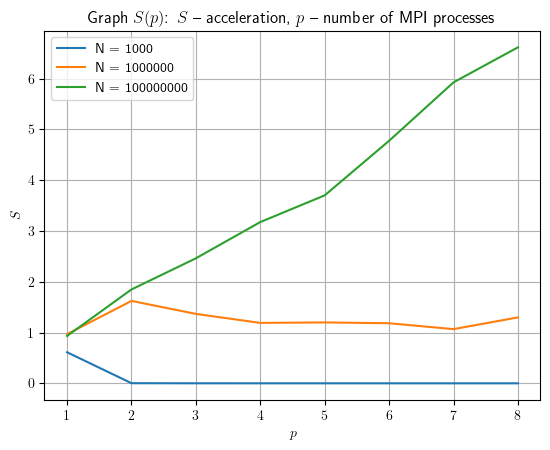

In [5]:
# Открываем файл с данными и собираем только нужные нам столбцы
df = pd.read_csv(MPI_DATA_FILE_NAME, sep=',', skipinitialspace = True)[['p', 'N', 'seq_time', 'par_time']]

# Считаем ускорение от параллельности
df['acceleration'] = df['seq_time'] / df['par_time']

# Группируем и усредняем наши данные
df = df.groupby(['N', 'p'], as_index=False).mean()

# Инициализируем среду pyplot
plt.rcParams['text.usetex'] = True
plt.grid()
plt.title(r'Graph $S(p)$: $S$ -- acceleration, $p$ -- number of MPI processes')
plt.xlabel(r'$p$')
plt.ylabel(r'$S$')

# Cтроим графики
for N in N_array:
    df_split = df.where(df['N'] == N)
    plt.plot(df_split['p'], df_split['acceleration'])

# Генерируем легенду
plt.legend(['N = {}'.format(n) for n in N_array])

# Наконец, результат
plt.savefig('mpi_graph.pdf', format='pdf')
plt.show()

Результат вполне ожидаемый. При отсутствии параллельности интерфейс сообщений либо не влияет на исполнение, либо замедляет его. При увеличении параллельности и вычислительной нагрузки параллельность существенно ускоряет задачу. 

## Чистый OpenMP

Конфигурация тестирования:
- `OMP_DATA_FILE_NAME` -- файл, в который будут собираться данные
  
- `RUNS_NUMBER` -- количество запусков программы для каждой пары (p, N) с целью усреднения
- `MAX_PROCESS_NUMBER` -- количество запускаемых процессов варьируется в диапазоне [1, `MAX_PROCESS_NUMBER`]
- `N_ARRAY` -- выбранные для тестирования разбиения отрезка интегрирования

In [6]:
OMP_DATA_FILE_NAME = 'data_omp.csv'

RUNS_NUMBER = 20
MAX_PROCESS_NUMBER = 8

N_array = [1000, 1000000, 100000000]

Подготовимся к сбору данных - cоздадим заголовок для таблицы. Данная реализация использует csv, заполняемый непосредственно кодом C++.

In [7]:
# Создаем файл для данных (удаляем имеющийся, если уже существует)
os.system('rm {}'.format(OMP_DATA_FILE_NAME))
csv_file = open(OMP_DATA_FILE_NAME, 'x')

# Пишем шапку таблицы
csv_file.write('p,    N,    seq_result,    seq_time,    par_result,    par_time\n')

# Закрываем файл
csv_file.close()

Теперь соберем статистику на разном количестве процессов (код для исполнения локально на машине).

In [8]:
for N in N_array:
    for process_number in range(1, MAX_PROCESS_NUMBER + 1):
        for run_number in range(1, RUNS_NUMBER + 1):
            print("\nCalculating run {} from {}: N = {}, p = {}\n".format(run_number, RUNS_NUMBER, N, process_number))
            os.system('{} {} {} {}'.format('../build/omp', process_number, N, '../data/' + OMP_DATA_FILE_NAME))


Calculating run 1 from 20: N = 1000, p = 1

Sequential calculation result: 3.14159248692
Sequential time: 0.000046
Process 0 resulted: 1.570796
Parallel calculation result: 3.14159248692
Parallel time: 0.000077
Difference between calculated results: 0.00000000000

Calculating run 2 from 20: N = 1000, p = 1

Sequential calculation result: 3.14159248692
Sequential time: 0.000135
Process 0 resulted: 1.570796
Parallel calculation result: 3.14159248692
Parallel time: 0.000153
Difference between calculated results: 0.00000000000

Calculating run 3 from 20: N = 1000, p = 1

Sequential calculation result: 3.14159248692
Sequential time: 0.000049
Process 0 resulted: 1.570796
Parallel calculation result: 3.14159248692
Parallel time: 0.000056
Difference between calculated results: 0.00000000000

Calculating run 4 from 20: N = 1000, p = 1

Sequential calculation result: 3.14159248692
Sequential time: 0.000131
Process 0 resulted: 1.570796
Parallel calculation result: 3.14159248692
Parallel time: 0.

Построим нужные нам графики зависимости ускорения S от количества процессов p.

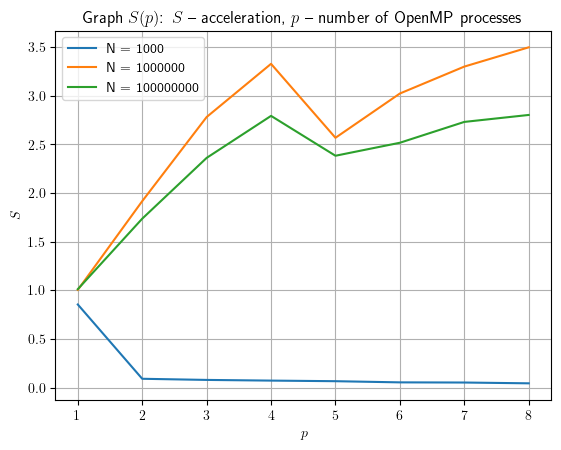

In [9]:
# Открываем файл с данными и собираем только нужные нам столбцы
df = pd.read_csv(OMP_DATA_FILE_NAME, sep=',', skipinitialspace = True)[['p', 'N', 'seq_time', 'par_time']]

# Считаем ускорение от параллельности
df['acceleration'] = df['seq_time'] / df['par_time']

# Группируем и усредняем наши данные
df = df.groupby(['N', 'p'], as_index=False).mean()

# Инициализируем среду pyplot
plt.rcParams['text.usetex'] = True
plt.grid()
plt.title(r'Graph $S(p)$: $S$ -- acceleration, $p$ -- number of OpenMP processes')
plt.xlabel(r'$p$')
plt.ylabel(r'$S$')

# Cтроим графики
for N in N_array:
    df_split = df.where(df['N'] == N)
    plt.plot(df_split['p'], df_split['acceleration'])

# Генерируем легенду
plt.legend(['N = {}'.format(n) for n in N_array])

# Наконец, результат
plt.savefig('omp_graph.pdf', format='pdf')
plt.show()

Результат несколько менее очевидный, чем в первом пункте работы. Максимальное ускорение получается при средней вычислительной нагрузке. Объяснить такую разницу можно только если недостаточной статистикой (задачи на фоне никак отменить невозможно). Профили ускорения также совпадают, кроме случая N = 1000, так как в этом случае параллельности не происходит, но время на запуск нового потока тратится.

# Бонусная часть (MPI + OpenMP)

Конфигурация тестирования:
- `MPI_OMP__DATA_FILE_NAME` -- файл, в который будут собираться данные
  
- `RUNS_NUMBER` -- количество запусков программы для каждой пары (p, N) с целью усреднения
- `CONFIG_ARRAY` -- конфигурации тестирования в формате `(p, n)`
  - `p` -- количество MPI процессов
  - `n` -- количество OpenMP потоков на процесс
- `N_ARRAY` -- выбранные для тестирования разбиения отрезка интегрирования

In [10]:
MPI_OMP_DATA_FILE_NAME = 'data_mpi_omp.csv'

RUNS_NUMBER = 20

CONFIG_ARRAY = [(1, 8), (2, 4), (4, 2), (8, 1)]

N_array = [1000, 1000000, 100000000]

Подготовимся к сбору данных - cоздадим заголовок для таблицы. Данная реализация использует csv, заполняемый непосредственно кодом C++.

In [11]:
# Создаем файл для данных (удаляем имеющийся, если уже существует)
os.system('rm {}'.format(MPI_OMP_DATA_FILE_NAME))
csv_file = open(MPI_OMP_DATA_FILE_NAME, 'x')

# Пишем шапку таблицы
csv_file.write('p,    n,    N,    seq_result,    seq_time,    par_result,    par_time\n')

# Закрываем файл
csv_file.close()

Теперь соберем статистику на разном количестве процессов (код для исполнения локально на машине).

In [12]:
for N in N_array:
    for p, n in CONFIG_ARRAY:
        for run_number in range(1, RUNS_NUMBER + 1):
            print("\nCalculating run {} from {}: N = {}, p = {}, n = {}\n".format(run_number, RUNS_NUMBER, N, p, n))
            os.system('mpirun --use-hwthread-cpus --oversubscribe -n {} {} {} {} {}'.format(p, '../build/mpi_omp', n, N, '../data/' + MPI_OMP_DATA_FILE_NAME))


Calculating run 1 from 20: N = 1000, p = 1, n = 8

Sequential calculation result: 3.14159248692
Sequential time: 0.000017
Process 0 returned 1.570796
Parallel calculation result: 3.14159248692
Parallel time: 0.000738
Difference between calculated results: 0.00000000000

Calculating run 2 from 20: N = 1000, p = 1, n = 8

Sequential calculation result: 3.14159248692
Sequential time: 0.000017
Process 0 returned 1.570796
Parallel calculation result: 3.14159248692
Parallel time: 0.000507
Difference between calculated results: 0.00000000000

Calculating run 3 from 20: N = 1000, p = 1, n = 8

Sequential calculation result: 3.14159248692
Sequential time: 0.000017
Process 0 returned 1.570796
Parallel calculation result: 3.14159248692
Parallel time: 0.000759
Difference between calculated results: 0.00000000000

Calculating run 4 from 20: N = 1000, p = 1, n = 8

Sequential calculation result: 3.14159248692
Sequential time: 0.000018
Process 0 returned 1.570796
Parallel calculation result: 3.14159

Построим нужные нам графики зависимости ускорения S от количества процессов p и потоков n.

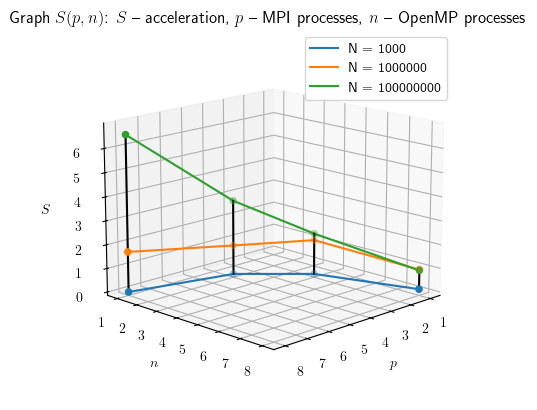

In [14]:
# Открываем файл с данными и собираем только нужные нам столбцы
df = pd.read_csv(MPI_OMP_DATA_FILE_NAME, sep=',', skipinitialspace = True)[['p', 'n', 'N', 'seq_time', 'par_time']]

# Считаем ускорение от параллельности
df['acceleration'] = df['seq_time'] / df['par_time']

# Группируем и усредняем наши данные
df = df.groupby(['p', 'n', 'N'], as_index=False).mean()

# Инициализируем среду pyplot
plt.rcParams['text.usetex'] = True
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(azim=45.0, elev=15.0)
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$n$')
ax.set_zlabel(r'$S$')
ax.set_zlim(0, df['acceleration'].max() * 1.05)
plt.title(r'Graph $S(p, n)$: $S$ -- acceleration, $p$ -- MPI processes, $n$ -- OpenMP processes')

# Cтроим графики
for N in N_array:
    df_split = df.where(df['N'] == N).dropna()
    ax.plot3D(df_split['p'], df_split['n'], df_split['acceleration'])

for N in N_array:
    df_split = df.where(df['N'] == N).dropna()
    ax.scatter(df_split['p'], df_split['n'], df_split['acceleration'])

for x, y in CONFIG_ARRAY:
    ax.plot3D([x, x], [y, y], [0, df.where((df['p'] == x) & (df['n'] == y))['acceleration'].max()], color='black')

# Генерируем легенду
plt.legend(['N = {}'.format(n) for n in N_array])

# Наконец, результат
plt.savefig('mpi_omp_graph.pdf', format='pdf')
plt.show()

Условием задана константность p*n=8, что совпадает с максимальным случаем первого пункта. Как видим, производительность растет от количества процессов MPI. Это объяснимо: процессы MPI способны занимать физические ядра (логические при `--use-hwthread-cpus --oversubscribe`, если доступен hyper-threading). При занятии меньшего числа ядер планировщик системы распределяет потокам OpenMP время в рамках одного ядра, потому общее количество процессорного времени меньше, чем при полном распараллеливании через MPI.

# Выводы

- Параллельность (действительная, не при количестве процессов равном 1) ощутимо ускоряет задачи, которые могут быть декомпозированы на параллельные процессы.
- MPI и OpenMP -- инструменты одного и того же толка, но работающие по-разному. MPI это физическая параллельность (кроме случая hyper-threading), а OpenMP -- логическая. Оба инструмента способны значительно ускорить исполнение, но потенциал MPI существенно выше (несмотря на большую сложность написания кода).
- В данном тесте получили максимальное ускорение ~6.5, что достаточно высокий показатель, учитывая недостаток времени на оптимизацию кода и местами наивное распределение нагрузки.
- Лучше всего распараллеливать наиболее вычислительно нагруженные участки кода, так как в противном случае время на распараллеливание и связанное с этим делегирование нивелирует выигрыш в производительности (видно по графикам для N = 1000).